<a href="https://colab.research.google.com/github/janputra/Physic-Informed-Neural-Networks-Practices-/blob/main/Copy_of_PINN_Disc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import pathlib 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import os
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from tensorflow.keras.utils import plot_model


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
## Training grid 
XMIN, XMAX = 0.0, 127500.0
TMIN, TMAX = 0.0, 100.0
Xmesh = np.linspace(XMIN, XMAX, 100).reshape((-1, 1))
Tmesh = np.linspace(TMIN, TMAX, 100).reshape((-1, 1))
X, T = np.meshgrid(Xmesh, Tmesh)

input_data = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

input_data

array([[0.00000000e+00, 0.00000000e+00],
       [1.28787879e+03, 0.00000000e+00],
       [2.57575758e+03, 0.00000000e+00],
       ...,
       [1.24924242e+05, 1.00000000e+02],
       [1.26212121e+05, 1.00000000e+02],
       [1.27500000e+05, 1.00000000e+02]])

In [ ]:
col_p=np.linspace(TMIN, TMAX, 2000).reshape((-1,1))
idx= np.random.choice(col_p.shape[0],1000, replace=False)

t_test=col_p[idx]
zero=np.zeros(t_test.shape[0])
x_end=XMAX*np.ones(t_test.shape[0])
t_test_init=np.hstack((zero.flatten()[:,None],t_test.flatten()[:,None]))
t_test_end=np.hstack((x_end.flatten()[:,None],t_test.flatten()[:,None]))

x_t0=np.linspace(XMIN, XMAX, 2000).reshape((-1,1))
idx= np.random.choice(col_p.shape[0],1000, replace=False)
x_test=x_t0[idx]
zero=np.zeros(x_test.shape[0])
BC_t0_x=np.hstack((x_test.flatten()[:,None],zero.flatten()[:,None]))


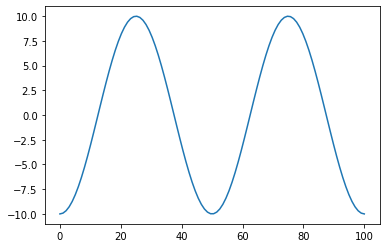

In [ ]:
# omega=2*math.pi*(1/50)

# temp=-10*np.exp(omega*1j*Tmesh)
# plt.figure()
# plt.plot(Tmesh,temp.real)

In [ ]:
def build_model(layers):
    i = Input(shape=(layers[0],))
    o = Dense(layers[1],activation="tanh")(i) 
    for x in layers[2:-1]:
        o = Dense(x,activation="tanh")(o)
    o = Dense(layers[-1],activation="linear")(o)
    model=Model(inputs=i, outputs=o)
    return model

In [ ]:
layers=[2,40,40,40,40,40,1]
model=build_model(layers)
model.summary()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [ ]:
  # The actual PINN
omega0 = tf.Variable([1.0], dtype=tf.float32)
omegal = tf.Variable([1.0], dtype=tf.float32)
c = tf.Variable([1.0], dtype=tf.float32)
k = tf.Variable([1.0], dtype=tf.float32)
A0=10
Al=-10
def pde():
    # Using the new GradientTape paradigm of TF2.0,
    # which keeps track of operations to get the gradient at runtime
    
    x_f = tf.convert_to_tensor(input_data[:, 0:1], dtype=tf.float32)
    t_f = tf.convert_to_tensor(input_data[:, 1:2], dtype=tf.float32)
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_f)
        tape.watch(t_f)
        X_f = tf.stack([x_f[:,0], t_f[:,0]], axis=1)
        
      # Getting the prediction
        u=model(X_f)
        # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
        u_x = tape.gradient(u, x_f)
        u_t = tape.gradient(u,t_f)
        
    u_tt = tape.gradient(u_t, t_f)
    u_xx= tape.gradient(u_x,x_f)
    
    # Letting the tape go
    del tape

    # Buidling the PINNs
    return u_xx+(u_tt/(c**2))

def bc_x0():
    t_f=tf.convert_to_tensor(t_test_init[:, 1:2], dtype=tf.float32)
    u=A0*tf.math.cos(omega0*t_f) 
    return u

def bc_xl():
    t_f=tf.convert_to_tensor(t_test_end[:, 1:2], dtype=tf.float32)
    u=Al*tf.math.cos(omegal*t_f) 
    return u

def bc_t0():

    x_f = tf.convert_to_tensor(BC_t0_x[:, 0:1], dtype=tf.float32)
    t_f = tf.convert_to_tensor(BC_t0_x[:, 1:2], dtype=tf.float32)
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_f)
        X_f = tf.stack([x_f[:,0], t_f[:,0]], axis=1)
        
      # Getting the prediction
        u=model(X_f)
        # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
        u_x = tape.gradient(u, x_f)
                
    u_xx= tape.gradient(u_x,x_f)
    
    # Letting the tape go
    del tape

    # Buidling the PINNs
    return u_xx + ((k)**2)*u 
   

def _wrap_training_variables():
    var=model.trainable_variables
    var.extend([omega0,omegal,k,c])
    return var

def _loss():
    f_pde=pde()
    f_bc_x0=bc_x0()
    f_bc_xl=bc_xl()
    f_bc_t0=bc_t0()
    return tf.reduce_mean(tf.square(f_pde)) + tf.reduce_mean(tf.square(f_bc_x0-model(t_test_init))) +tf.reduce_mean(tf.square(f_bc_xl-model(t_test_end)))+tf.reduce_mean(tf.square(f_bc_t0))

def _grad():
    with tf.GradientTape() as tape:
          loss_value = _loss()
    return loss_value, tape.gradient(loss_value, _wrap_training_variables())

def fit():
    for epoch in range(epochs):
        # Optimization step
        loss_value, grads = _grad()
        optimizer.apply_gradients(zip(grads, _wrap_training_variables()))
        if epoch%50==0:
          print ('epoch : ',epoch,' loss : ',loss_value )
    # print ('epoch : ',epoch,' loss : ',loss_value )

def predict(x):
    return model(x)


In [ ]:
optimizer = tf.keras.optimizers.Adam(
  learning_rate=0.001)

In [ ]:
epochs = 100000
fit() 


epoch :  0  loss :  tf.Tensor(78.2713, shape=(), dtype=float32)
epoch :  50  loss :  tf.Tensor(78.17924, shape=(), dtype=float32)
epoch :  100  loss :  tf.Tensor(78.10553, shape=(), dtype=float32)
epoch :  150  loss :  tf.Tensor(78.05156, shape=(), dtype=float32)
epoch :  200  loss :  tf.Tensor(77.99486, shape=(), dtype=float32)
epoch :  250  loss :  tf.Tensor(77.94881, shape=(), dtype=float32)
epoch :  300  loss :  tf.Tensor(77.90787, shape=(), dtype=float32)
epoch :  350  loss :  tf.Tensor(77.87044, shape=(), dtype=float32)
epoch :  400  loss :  tf.Tensor(77.835464, shape=(), dtype=float32)
epoch :  450  loss :  tf.Tensor(77.80216, shape=(), dtype=float32)
epoch :  500  loss :  tf.Tensor(77.76997, shape=(), dtype=float32)
epoch :  550  loss :  tf.Tensor(77.738396, shape=(), dtype=float32)
epoch :  600  loss :  tf.Tensor(77.70711, shape=(), dtype=float32)
epoch :  650  loss :  tf.Tensor(77.70693, shape=(), dtype=float32)
epoch :  700  loss :  tf.Tensor(77.64485, shape=(), dtype=float3

In [ ]:
Xmesh1 = np.linspace(XMIN, XMAX, 1000).reshape((-1, 1))
Tmesh1 = np.linspace(TMIN, TMAX, 200).reshape((-1, 1))
X1, T1 = np.meshgrid(Xmesh1, Tmesh1)

d_test=np.hstack((X1.flatten()[:,None], T1.flatten()[:,None]))
d_test.shape




(200000, 2)

In [ ]:
res=model(d_test)
res=res.numpy()
res=res.reshape(Xmesh1.shape[0],Tmesh1.shape[0])

res.shape

NameError: ignored

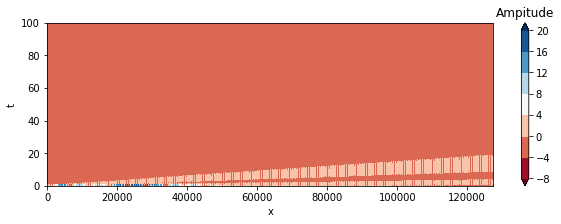

In [ ]:
plt.figure(figsize=(10,3))
plt.xlabel('x')
plt.ylabel('t')

# levels=np.arange(-amp,amp,0.00001)
#plt.contourf(A,B,res.T,levels,cmap='RdBu',extend='both' )
plt.contourf(X1,T1,res.T,cmap='RdBu',extend='both' )
clb = plt.colorbar()
clb.ax.set_title('Ampitude')
plt.show()

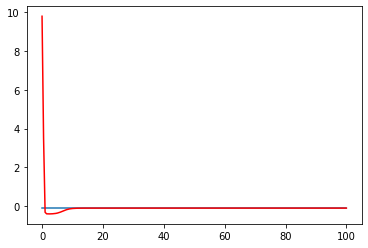

In [ ]:
plt.figure()
plt.plot(Tmesh1,res[999,:])
plt.plot(Tmesh1,res[0,:],color='r')


